In [11]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white


eda_middle_data_path = 'eda-middle-data/'

res = pd.DataFrame([], columns=['pcode', 'max_amplitude', 'scr_count_per_minute'])
measurement = 'scr_count_per_minute'

# calculate mean SCRs frequency for each participant
for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = eda_middle_data_path + participant_key + '_eda_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist.')
        continue

    df = pd.read_csv(file_path)
    
    # filter out participants with less than 5 rows of data 
    if len(df) < 5:
        print(file_path + ' has too less data, filtered out')
        continue

    # IQR procedure to remove outlier
    Q1 = df[measurement].quantile(0.25)
    Q3 = df[measurement].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = ((df[measurement] < (Q1 - 1.5 * IQR)) | (df[measurement] > (Q3 + 1.5 * IQR)))
    
    df_filtered = df[~outliers]

    # In the end, we only use the scr_count_per_minute.
    res.loc[len(res)] = [participant_key, df_filtered['max_amplitude'].mean(), df_filtered['scr_count_per_minute'].mean()]

res

eda-middle-data/P01_eda_result.csv do not exist.
eda-middle-data/P04_eda_result.csv has too less data, filtered out
eda-middle-data/P08_eda_result.csv has too less data, filtered out
eda-middle-data/P27_eda_result.csv do not exist.
eda-middle-data/P29_eda_result.csv has too less data, filtered out
eda-middle-data/P48_eda_result.csv has too less data, filtered out
eda-middle-data/P49_eda_result.csv has too less data, filtered out
eda-middle-data/P59_eda_result.csv do not exist.
eda-middle-data/P65_eda_result.csv do not exist.
eda-middle-data/P73_eda_result.csv has too less data, filtered out
eda-middle-data/P74_eda_result.csv has too less data, filtered out
eda-middle-data/P75_eda_result.csv has too less data, filtered out
eda-middle-data/P76_eda_result.csv do not exist.


,pcode,max_amplitude,scr_count_per_minute
0,P02,0.428688,2.434815
1,P03,0.213410,1.732859
2,P05,0.372123,2.809771
3,P06,0.475930,2.360475
4,P07,0.284868,2.397431
...,...,...,...
62,P72,0.167180,2.476707
63,P77,0.302342,2.909111
64,P78,0.195330,2.553603
65,P79,2.034908,2.388313


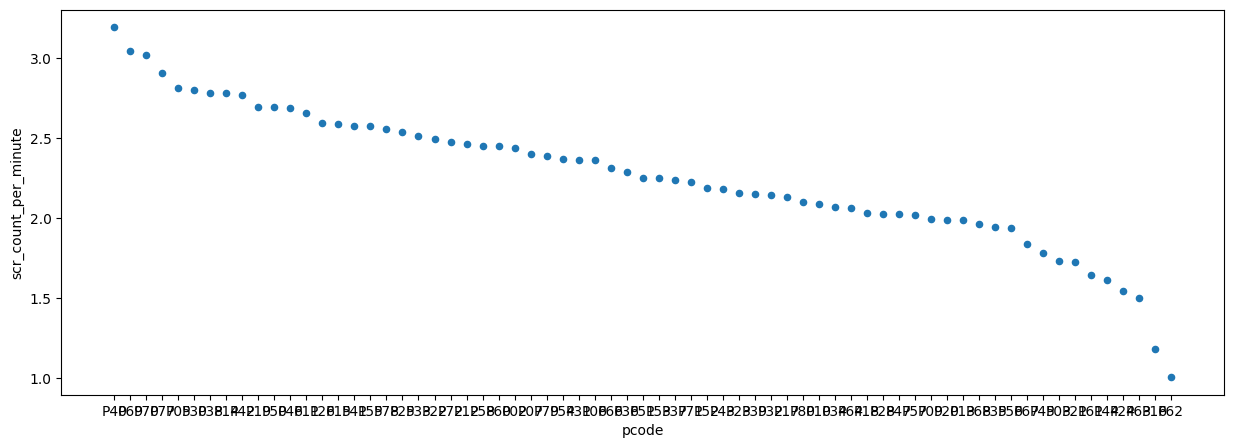

In [12]:
# plot overview of participants
res.sort_values(by=measurement, ascending=False, inplace=True)
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))

In [13]:
# read participant information and print result for overview
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


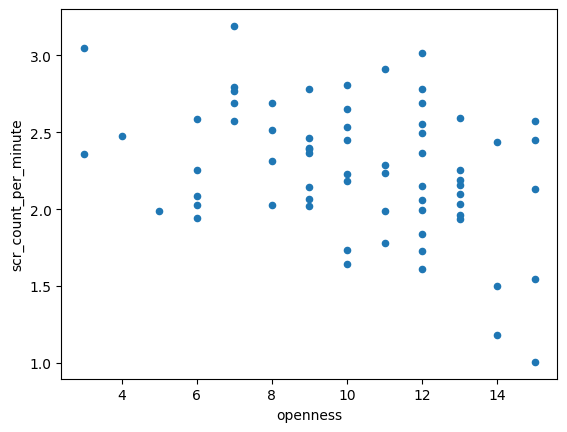

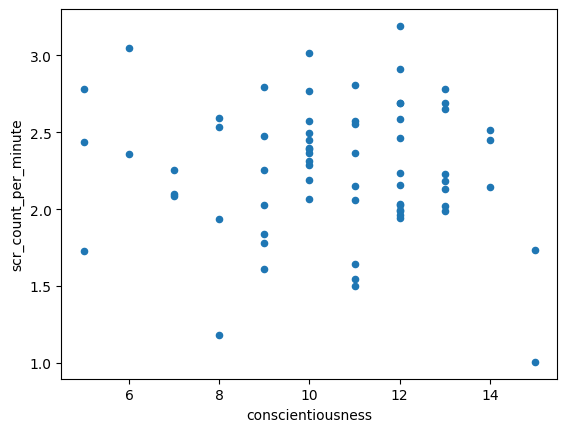

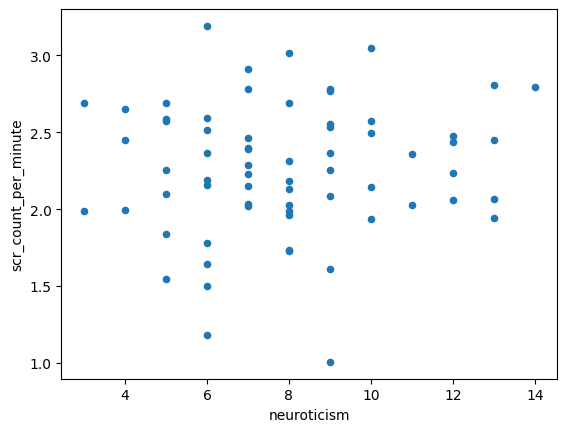

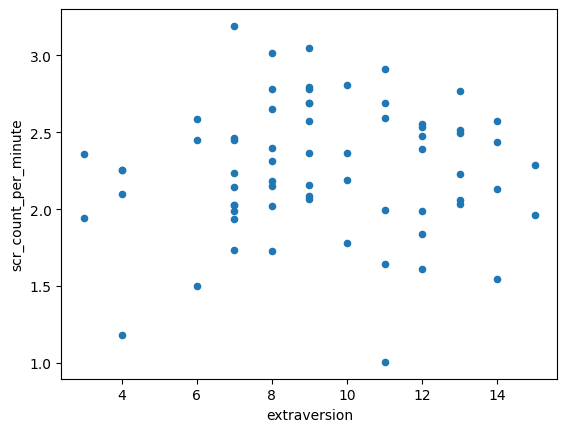

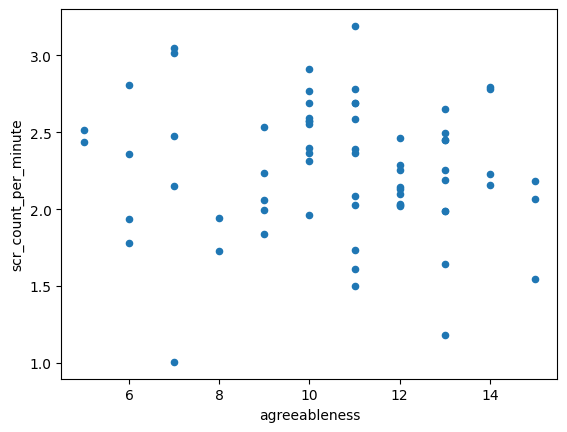

In [14]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

output_path = 'analyse_data/'
Path(output_path).mkdir(parents=True, exist_ok=True)

df_test.to_csv(f'{output_path}eda-results.csv', index=False)

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [15]:
# join user information dataframe and HRV result dataframe
X = df_test[personality_traits]
y = df_test[measurement]

# multiple regression model for all five personality traits to EDA
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     scr_count_per_minute   R-squared:                       0.154
Model:                              OLS   Adj. R-squared:                  0.085
Method:                   Least Squares   F-statistic:                     2.229
Date:                  Thu, 13 Jun 2024   Prob (F-statistic):             0.0627
Time:                          22:36:48   Log-Likelihood:                -32.013
No. Observations:                    67   AIC:                             76.03
Df Residuals:                        61   BIC:                             89.25
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

ShapiroResult(statistic=0.9933157356038232, pvalue=0.977437136569229)


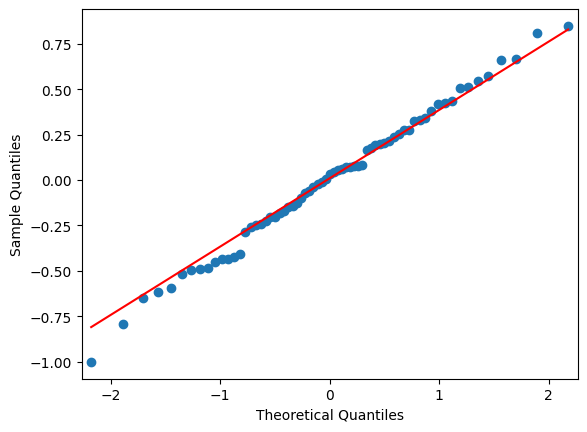

In [16]:
# normality test
qq_plot = sm.qqplot(results.resid, line='q')
print(scipy.stats.shapiro(results.resid))

In [17]:
# Pearson correlation of each personality trait to EDA. We don't use them in the end.
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=-0.3662411106248573, pvalue=0.002303257772774621)
conscientiousness PearsonRResult(statistic=-0.07972955048538433, pvalue=0.5212919458234374)
neuroticism PearsonRResult(statistic=0.08886643181544973, pvalue=0.4745282039552714)
extraversion PearsonRResult(statistic=0.0498339421944161, pvalue=0.6888022950508113)
agreeableness PearsonRResult(statistic=-0.09710099849262428, pvalue=0.43439192209382743)


In [18]:
# assumption test for homogeneity
homogeneity_test_results = het_white(results.resid, results.model.exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
homogeneity_test_results = dict(zip(labels, homogeneity_test_results))

print(homogeneity_test_results)

{'Lagrange multiplier statistic': 24.560241688999728, 'p-value': 0.21877558025455798, 'f-value': 1.3310291606928801, 'f p-value': 0.2084285762964327}


In [19]:
p2 = ['openness', 'conscientiousness']
X2 = df_test[p2]

X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2)
results2 = model2.fit()
print(results2.summary())

                             OLS Regression Results                             
Dep. Variable:     scr_count_per_minute   R-squared:                       0.136
Model:                              OLS   Adj. R-squared:                  0.109
Method:                   Least Squares   F-statistic:                     5.055
Date:                  Thu, 13 Jun 2024   Prob (F-statistic):            0.00915
Time:                          22:36:48   Log-Likelihood:                -32.721
No. Observations:                    67   AIC:                             71.44
Df Residuals:                        64   BIC:                             78.06
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

In [20]:
print(scipy.stats.shapiro(results2.resid))

homogeneity_test_results = het_white(results2.resid, results2.model.exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
homogeneity_test_results = dict(zip(labels, homogeneity_test_results))

print(homogeneity_test_results)

ShapiroResult(statistic=0.9898098061992008, pvalue=0.8618784925025994)
{'Lagrange multiplier statistic': 7.164275298170947, 'p-value': 0.20870683308040233, 'f-value': 1.4607353562313212, 'f p-value': 0.21585624509078588}


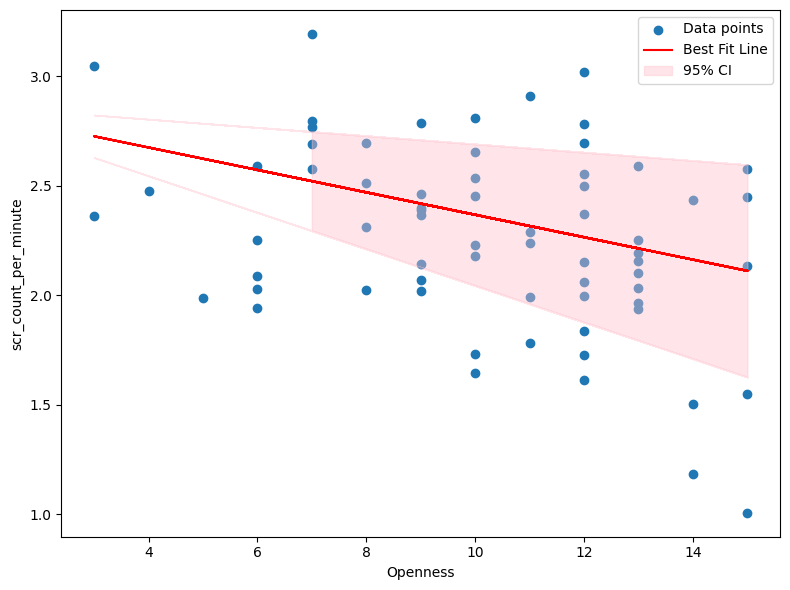

In [21]:
import matplotlib.pyplot as plt

coef_openness = results2.params['openness']
std_err_openness = results2.bse['openness']
intercept = results2.params['const']

# calculate 95% confidence interval
lower_ci = coef_openness - 1.96 * std_err_openness
upper_ci = coef_openness + 1.96 * std_err_openness

plt.figure(figsize=(8, 6))
plt.scatter(df_test['openness'], y, label='Data points')
plt.plot(df_test['openness'], intercept + coef_openness * df_test['openness'], color='red', label='Best Fit Line')
plt.fill_between(df_test['openness'], intercept + lower_ci * df_test['openness'], intercept + upper_ci * df_test['openness'], color='pink', alpha=0.4, label='95% CI')
plt.xlabel('Openness')
plt.ylabel('scr_count_per_minute')
plt.legend()

plt.tight_layout()
plt.show()
